In [292]:
from utils.get_data import get_loaders, inv_normalize, normalize, classes
from utils.utils import get_model_metrics
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TTF
import torchvision.transforms as transforms
from models.teachers import get_teachers
from models.student import get_student
from models.blackbox import get_blackbox
from PIL import Image
import torch.nn.functional as F
from attacks.attacks import *
from per_class_attack_test import rmsd_per_sample
from pytorch_grad_cam import GradCAM, EigenCAM, ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

In [319]:
def scale(img_tensor, size=(200, 200)):
    return TTF.resize(img_tensor, size, interpolation=TTF.InterpolationMode.BICUBIC)

transform_for_model = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# pass un normalized and upscaled image here
def show_image(img_tensor, title=None):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)  # clip to valid range
    plt.imshow(img_np)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def display_examples(imgs, noises, titles, noise_titles, fontsize=10):
    fig, axes = plt.subplots(2, 4)
    for i in range(len(imgs)):
        inv_img = inv_normalize(imgs[i].squeeze(0)).cpu().numpy()
        inv_noise = inv_normalize(noises[i].squeeze(0)).cpu().numpy()
        axes[0,i].imshow(np.transpose(inv_img, (1, 2, 0)))
        axes[0,i].set_title(titles[i], fontsize=fontsize)
        axes[1,i].imshow(np.transpose(inv_noise, (1, 2, 0)))
        axes[1,i].set_title(noise_titles[i], fontsize=fontsize)
        axes[0,i].set_xticks([])
        axes[0,i].set_yticks([])
        axes[1,i].set_xticks([])
        axes[1,i].set_yticks([])
    plt.tight_layout()
    plt.show()

def display_examples_with_cam(imgs, noises, titles, noise_titles, cam_images, fontsize=10):
    fig, axes = plt.subplots(3, 4)
    for i in range(len(imgs)):
        inv_img = inv_normalize(imgs[i].squeeze(0)).cpu().numpy()
        inv_noise = inv_normalize(noises[i].squeeze(0)).cpu().numpy()
        axes[0,i].imshow(np.transpose(inv_img, (1, 2, 0)))
        axes[0,i].set_title(titles[i], fontsize=fontsize)
        axes[1,i].imshow(np.transpose(inv_noise, (1, 2, 0)))
        axes[1,i].set_title(noise_titles[i], fontsize=fontsize)
        axes[2,i].imshow(cam_images[i])
        axes[0, i].axis('off')
        axes[1, i].axis('off')
        axes[2, i].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# add upscaled adv_pertubation and gradcam 
img_high_res = Image.open('sample_images/mochi.jpg').convert('RGB')
# pass normalized 32x32 to the model to generate adv example 
img_32 = scale(img_high_res, size=(32,32))
img = transform_for_model(img_32).unsqueeze(0)

In [227]:
# test if all models can correctly guess
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img = img.to(device)
label = torch.tensor([3], dtype=torch.int64, device=device) # 3 for 'cat'
res50, dense = get_teachers()
googlenet = get_blackbox()
stu = get_student(pretrained=False)
# Best Results Model
cpt = f"checkpoints_experiment_2/stu_resnet18_a_03_t_1.cpt"
stu.load_state_dict(torch.load(cpt))
stu = stu.eval()
models = [res50, dense, googlenet, stu]
for model in models:
    model = model.eval().to(device)
    out: torch.Tensor = model(img)
    print(F.softmax(out, dim=1)*100)
    pred = out.argmax(1).squeeze(0).item()
    print(classes[pred])

tensor([[1.1068e-01, 9.2951e-02, 1.3353e-01, 9.8660e+01, 1.4649e-01, 3.8970e-01,
         1.6102e-01, 1.3822e-01, 8.1755e-02, 8.5344e-02]], device='cuda:0',
       grad_fn=<MulBackward0>)
cat
tensor([[ 0.2132,  0.1875,  0.2599, 97.6696,  0.2555,  0.5267,  0.2637,  0.2296,
          0.1965,  0.1978]], device='cuda:0', grad_fn=<MulBackward0>)
cat
tensor([[2.5789e-02, 2.6748e-02, 4.9482e-02, 9.9672e+01, 3.5026e-02, 7.8373e-02,
         3.2652e-02, 3.2037e-02, 2.2816e-02, 2.4651e-02]], device='cuda:0',
       grad_fn=<MulBackward0>)
cat
tensor([[4.1068e-02, 2.6190e-01, 1.0482e-01, 9.7078e+01, 2.3362e-02, 1.8033e+00,
         3.5102e-01, 1.4079e-01, 1.0578e-01, 8.9537e-02]], device='cuda:0',
       grad_fn=<MulBackward0>)
cat


In [313]:
fgsm_img = fgsm_attack(stu, img, label, epsilon=18/255)
fgm_img = fgm_attack(stu, img, label, epsilon=3.95)
pgd_img = pgd_attack(stu, img, label, epsilon=20.0/255, alpha=2/255, num_steps=50)
# fgsm_img = fgsm_attack(stu, img, label, epsilon=2*(18/255))
# fgm_img = fgm_attack(stu, img, label, epsilon=2*(3.95))
# pgd_img = pgd_attack(stu, img, label, epsilon=2*(20.0/255), alpha=2/255, num_steps=50)
print(rmsd_per_sample(img,fgsm_img).item())
print(rmsd_per_sample(img,fgm_img).item())
print(rmsd_per_sample(img,pgd_img).item())

4.510782241821289
4.521739482879639
4.515364646911621


In [307]:
imgs = [img, fgsm_img, fgm_img, pgd_img]
titles = ["Real", "FGSM", "FGM", "PGD"]
noises = []
noise_titles = []
noise_mult = 4
for i in range(len(imgs)):
    cur_img = imgs[i]
    noises.append(noise_mult*(img - cur_img)) # real - adv image
    model = googlenet.eval().to(device)
    out: torch.Tensor = model(cur_img)
    pred = out.argmax(1).squeeze(0).item()
    suffix = f" ({classes[pred]} {F.softmax(out, dim=1)[:,pred].item()*100:.1f}%)"
    titles[i] = titles[i] + suffix
    noise_titles.append(f"RMSD(delta)={rmsd_per_sample(img,cur_img).item():.1f}")
print(titles)


['Real (cat 99.7%)', 'FGSM (frog 88.5%)', 'FGM (frog 53.7%)', 'PGD (dog 59.2%)']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1185152e-08..0.8235294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1185152e-08..0.84097177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1185152e-08..0.8376497].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1187101..1.0280927].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1185152e-08..0.80414903].


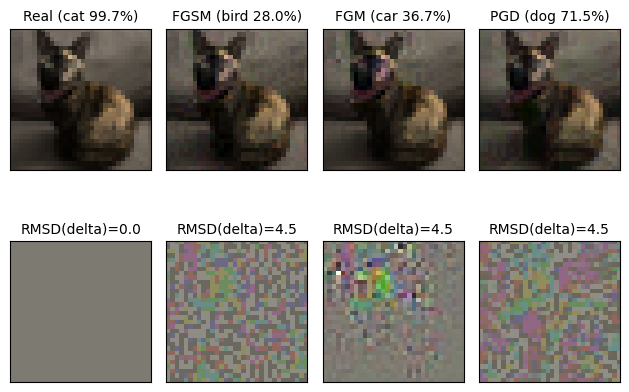

In [257]:
display_examples(imgs, noises, titles, noise_titles)

In [325]:
img_high_res = Image.open('sample_images/mochi.jpg').convert('RGB')
# pass normalized 32x32 to the model to generate adv example 
img_250 = scale(img_high_res, size=(250,250))
img_250 = transform_for_model(img_250).unsqueeze(0).to(device)

# high res version
imgs_high_res = []
imgs = [img, fgsm_img, fgm_img, pgd_img]
titles = ["Real", "FGSM", "FGM", "PGD"]
noise_titles = []
noises_high_res = []
noise_mult = 3

for i in range(len(imgs)):
    cur_img = imgs[i]
    cur_noise = img - cur_img
    cur_noise_250 = scale(cur_noise, size=(250,250))
    noises_high_res.append(noise_mult*cur_noise_250) # real - adv image
    cur_img_high_res = img_250 + cur_noise_250
    imgs_high_res.append(cur_img_high_res)
    model = googlenet.eval().to(device)
    out: torch.Tensor = model(cur_img)
    pred = out.argmax(1).squeeze(0).item()
    suffix = f" ({classes[pred]} {F.softmax(out, dim=1)[:,pred].item()*100:.1f}%)"
    titles[i] = titles[i] + suffix
    noise_titles.append(f"RMSD(delta)={rmsd_per_sample(img,cur_img).item():.1f}")
print(titles)
print(noise_titles)

['Real (cat 99.7%)', 'FGSM (bird 28.0%)', 'FGM (car 36.7%)', 'PGD (dog 91.2%)']
['RMSD(delta)=0.0', 'RMSD(delta)=4.5', 'RMSD(delta)=4.5', 'RMSD(delta)=4.5']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1185152e-08..0.93333334].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02336853..0.9222073].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.048173636..0.925801].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024797963..0.93884313].


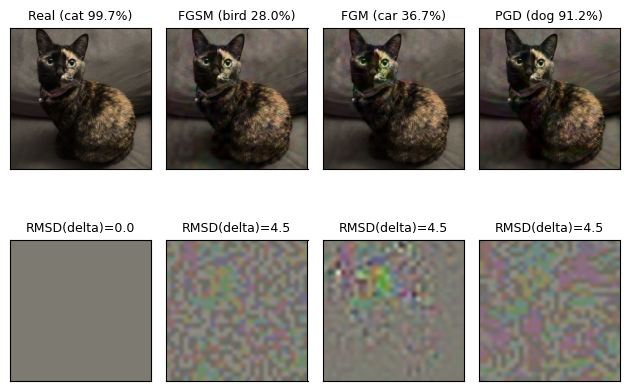

In [326]:
display_examples(imgs_high_res, noises_high_res, titles, noise_titles, fontsize=9)

In [323]:
# grad cam
img_high_res = Image.open('sample_images/mochi.jpg').convert('RGB')
# pass normalized 32x32 to the model to generate adv example 
img_250 = scale(img_high_res, size=(250,250))
img_250 = transform_for_model(img_250).unsqueeze(0).to(device)

# high res version
imgs_high_res = []
imgs = [img, fgsm_img, fgm_img, pgd_img]
titles = ["Real", "FGSM", "FGM", "PGD"]
noise_titles = []
noises_high_res = []
noise_mult = 3
cam_images = []
target_layer = googlenet.inception5b.branch3

cam = ScoreCAM(model=googlenet, target_layers=[target_layer])
for i in range(len(imgs)):
    cur_img = imgs[i]
    cur_noise = img - cur_img
    cur_noise_250 = scale(cur_noise, size=(250,250))
    noises_high_res.append(noise_mult*cur_noise_250) # real - adv image
    cur_img_high_res = img_250 + cur_noise_250
    imgs_high_res.append(cur_img_high_res)
    model = googlenet.eval().to(device)
    out: torch.Tensor = model(cur_img)
    pred = out.argmax(1).squeeze(0).item()
    suffix = f" ({classes[pred]} {F.softmax(out, dim=1)[:,pred].item()*100:.1f}%)"
    titles[i] = titles[i] + suffix
    noise_titles.append(f"RMSD(delta)={rmsd_per_sample(img,cur_img).item():.1f}")
    # grad cam
    grayscale_cam = cam(input_tensor=cur_img, aug_smooth=True)[0]
    grayscale_cam_resized = cv2.resize(grayscale_cam, (250, 250))
    display_img_np = inv_normalize(cur_img_high_res).squeeze(0).permute(1, 2, 0).cpu().numpy()
    display_img_np = np.clip(display_img_np, 0, 1)
    cam_image = show_cam_on_image(display_img_np, grayscale_cam_resized, use_rgb=True)
    cam_images.append(cam_image)
print(titles)
print(noise_titles)

100%|██████████| 8/8 [00:00<00:00, 91.63it/s]

['Real (cat 99.7%)', 'FGSM (bird 28.0%)', 'FGM (car 36.7%)', 'PGD (dog 91.2%)']
['RMSD(delta)=0.0', 'RMSD(delta)=4.5', 'RMSD(delta)=4.5', 'RMSD(delta)=4.5']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1185152e-08..0.93333334].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02336853..0.9222073].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.048173636..0.925801].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024797963..0.93884313].


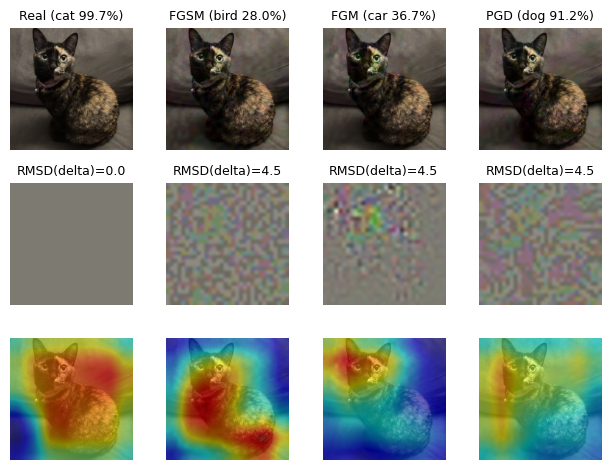

In [324]:
display_examples_with_cam(imgs_high_res, noises_high_res, titles, noise_titles, cam_images,fontsize=9)